# 사전 준비

## 패키지 import

In [19]:
import os
import numpy as np
import pandas as pd

import pydot
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import Image 

from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score

In [20]:
os.environ['PATH'] += os.pathsep + 'C:/Program Files/Graphviz/bin'

## 데이터 로드

In [21]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 최종 데이터 셋 확정

In [22]:
feature_names = list(df.columns[:-1])
x = df.loc[:, feature_names].to_numpy()
y = df.iloc[:, -1].to_numpy()
class_names = ['0', '1']

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=184)

# Decision Tree 시각화

## Decision tree 그리는 함수 정의

In [6]:
def draw_decision_tree(clf):
    global feature_names
    global class_names
    dot_data = export_graphviz(clf, out_file = None, 
                                feature_names = feature_names,
                                class_names = class_names,
                                filled = True, 
                                rounded = True,
                                special_characters = True)
    graph = pydot.graph_from_dot_data(dot_data)[0]
    image = graph.create_png()
    return Image(image)

## 학습

### 학습 전략 1- 사전 가지치기

In [7]:
clf = DecisionTreeClassifier()
full_tree = clf.fit(x_train, y_train)

In [8]:
hyperparamters = {'max_depth': list(range(2, 8)),  'min_samples_split': list(range(2, 20))}

In [9]:
GridCV = GridSearchCV(estimator=full_tree, param_grid=hyperparamters, cv=5, verbose=1)
GridCV.fit(x_train, y_train)
params = GridCV.best_params_
params

Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 2, 'min_samples_split': 2}

In [10]:
clf = DecisionTreeClassifier(max_depth=params['max_depth'], min_samples_split=params['min_samples_split'], random_state=0)
pruned_tree = clf.fit(x_train, y_train)

최종 시각화 및 Accuracy

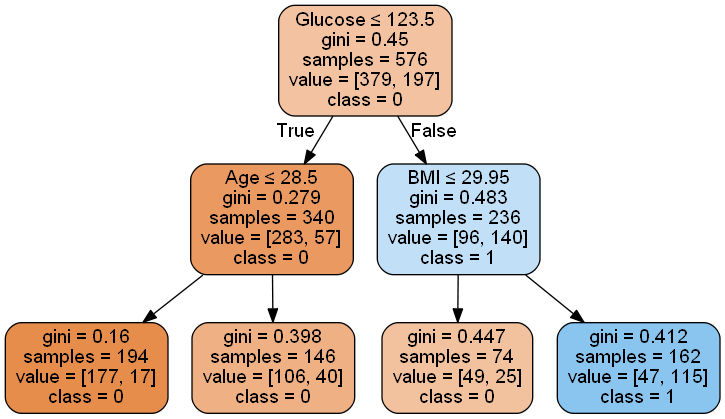

In [11]:
draw_decision_tree(pruned_tree)

In [12]:
acc = accuracy_score(y_test, pruned_tree.predict(x_test))
print(f'사전 가지치기를 이용한 최종 성능 {acc: .3f}')

사전 가지치기를 이용한 최종 성능  0.729


### 학습 전략 2-사후 가지치기

In [13]:
clf = DecisionTreeClassifier(random_state=0)
cpp = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = cpp.ccp_alphas, cpp.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

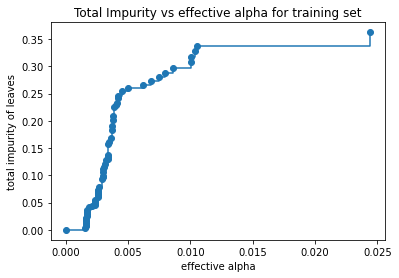

In [14]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [15]:
clfs = []
for count, ccp_alpha in enumerate(ccp_alphas):
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf = clf.fit(x_train, y_train)
    print(f"Number of nodes in the {count}th tree is: {clf.tree_.node_count} with ccp_alpha: {ccp_alpha}")
    clfs.append(clf)
    print("====================================================================================")

Number of nodes in the 0th tree is: 205 with ccp_alpha: 0.0
Number of nodes in the 1th tree is: 201 with ccp_alpha: 0.0015432098765432098
Number of nodes in the 2th tree is: 193 with ccp_alpha: 0.0016025641025641019
Number of nodes in the 3th tree is: 193 with ccp_alpha: 0.0016025641025641019
Number of nodes in the 4th tree is: 189 with ccp_alpha: 0.001612103174603175
Number of nodes in the 5th tree is: 185 with ccp_alpha: 0.0016276041666666667
Number of nodes in the 6th tree is: 181 with ccp_alpha: 0.0016493055555555551
Number of nodes in the 7th tree is: 177 with ccp_alpha: 0.001660628019323672
Number of nodes in the 8th tree is: 173 with ccp_alpha: 0.0016718106995884767
Number of nodes in the 9th tree is: 169 with ccp_alpha: 0.0016835016835016823
Number of nodes in the 10th tree is: 165 with ccp_alpha: 0.0016999421296296318
Number of nodes in the 11th tree is: 161 with ccp_alpha: 0.001719732704402512
Number of nodes in the 12th tree is: 155 with ccp_alpha: 0.001893939393939394
Numbe

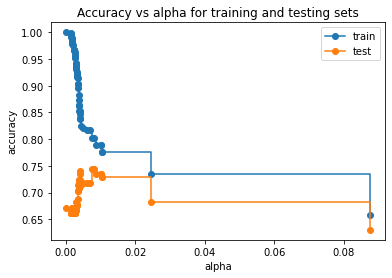

Decision tree without pruning : 217 nodes, Score : 0.672
Decision tree with the best pruning : 17 nodes, Score : 0.745


In [16]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print(f"Decision tree without pruning : {full_tree.tree_.node_count} nodes, Score : {full_tree.score(x_test, y_test):.3f}")
print(f"Decision tree with the best pruning : {clfs[test_scores.index(max(test_scores))].tree_.node_count} nodes, Score : {max(test_scores):.3}")

최종 시각화 및  Accuracy

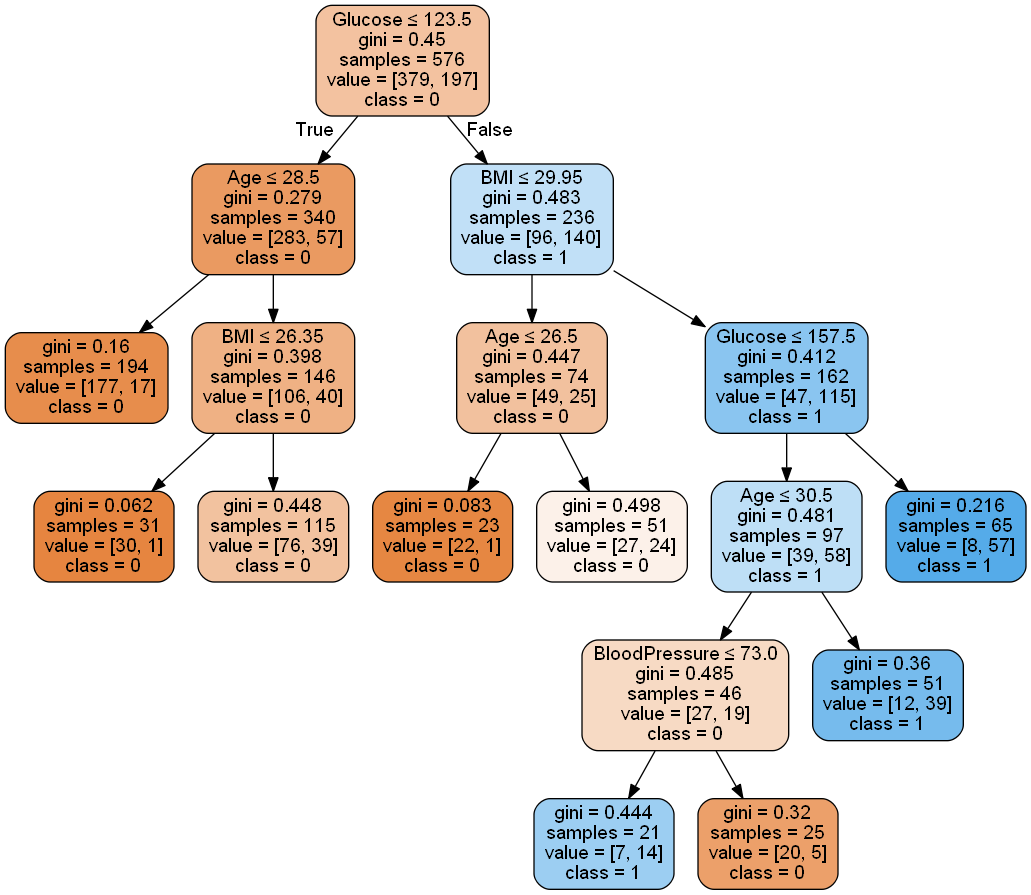

In [17]:
best_clf = clfs[test_scores.index(max(test_scores))]
draw_decision_tree(best_clf)

In [18]:
acc = accuracy_score(y_test, best_clf.predict(x_test))
print(f'사후 가지치기를 이용한 최종 성능 {acc: .3f}')

사후 가지치기를 이용한 최종 성능  0.745
